# Preprocessing for Bridal Couture Dataset
Following are the various preprocessing steps done for the custom bridal couture dataset curated to explore CycleGAN's effectiveness in cross-culture translation. 

In [ ]:
!pip install rembg retina-face opencv-python-headless matplotlib onnxruntime retina_face


### 1. Extracting Images
For websites with dynamic content rendering and lazy loadings, full page scrolls were performed and were saved as PDFs. The images were then extracted from the PDFs using pdf2image. 

In [ ]:
import os
import fitz  # PyMuPDF
from pdf2image import convert_from_path

# --------------------------
# Settings
# --------------------------
PDF_DIR = '/Users/sathammai/Desktop/Indian'   # folder with all PDFs
OUTPUT_DIR = '/Users/sathammai/Desktop/IndianMAIN'  # single folder for all images
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------
# Function to extract images from a single PDF
# --------------------------
def extract_images_from_pdf(pdf_path, output_folder, pdf_name):
    doc = fitz.open(pdf_path)
    embedded_count = 0

    for page_num in range(len(doc)):
        for img_index, img in enumerate(doc[page_num].get_images(full=True)):
            xref = img[0]
            pix = fitz.Pixmap(doc, xref)
            out_path = os.path.join(output_folder, f"{pdf_name}_page{page_num+1}_img{img_index+1}.png")
            if pix.n < 5:
                pix.save(out_path)
            else:
                pix = fitz.Pixmap(fitz.csRGB, pix)
                pix.save(out_path)
            embedded_count += 1

    doc.close()
    return embedded_count

# --------------------------
# Process all PDFs in the folder
# --------------------------
for filename in os.listdir(PDF_DIR):
    if filename.lower().endswith('.pdf'):
        pdf_path = os.path.join(PDF_DIR, filename)
        pdf_name = os.path.splitext(filename)[0]

        print(f"Processing: {filename} ...")
        embedded_count = extract_images_from_pdf(pdf_path, OUTPUT_DIR, pdf_name)

        if embedded_count == 0:
            print("No embedded images found, rendering full pages instead...")
            pages = convert_from_path(pdf_path)
            for i, page in enumerate(pages):
                page.save(os.path.join(OUTPUT_DIR, f"{pdf_name}_page_{i+1}.png"), 'PNG')
            print(f"Rendered {len(pages)} pages as images.")
        else:
            print(f"Extracted {embedded_count} embedded images.")

print("All PDFs processed successfully! All images saved in one folder.")

For websites whose contents were rendered through Vue or Angular, the above script did not work. The images had to therefore be extracted using Playwright or Selenium. Those Scripts are not included here because the script changed depending on the site structure. 

### 2. Augmentations
The images in the Western dataset were lesser than the images in the Indian dataset due to the lack of high-quality Western bridal couture images on the internet. Therefore, a subset of images were selected from the Western dataset for augmentation. Augmentations were chosen safely, i.e. as to not distort the fabric and to be photo-realistic. These augmented images were then added to the Western dataset. 

In [ ]:
# pip install albumentations opencv-python tqdm
import os
import random
from glob import glob
import cv2
import albumentations as A
from tqdm import tqdm

# -------- SETTINGS --------
src_folder = '/Users/sathammai/Desktop/augmentable pictures '       # folder with the 5k western images
out_folder = "/Users/sathammai/Desktop/augmentED" # where augmented images will be placed
os.makedirs(out_folder, exist_ok=True)

# how many images to pick for augmentation 
N_AUG = 900

# seed for reproducibility
SEED = 42
random.seed(SEED)

# acceptable input extensions
EXTS = ('.jpg', '.jpeg', '.png', '.webp')

# -------------------------
# define 5 safe augmentations (photorealistic + fabric-preserving)

transforms = [
    A.HorizontalFlip(p=1.0),  # nice for pose variation; preserves details
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.06, rotate_limit=12, border_mode=cv2.BORDER_REFLECT_101, p=1.0),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.12, p=1.0),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=1.0),
    A.OneOf([A.Affine(shear=6, p=1.0), A.Perspective(scale=(0.02,0.06), p=1.0)], p=1.0),
    A.RandomGamma(gamma_limit=(80,120), p=1.0)
]

# small helper: keep image size roughly same by resizing back to original dims
def apply_aug(img, aug):
    res = aug(image=img)
    out = res['image']
    return out

# gather images
all_imgs = []
for ext in EXTS:
    all_imgs.extend(glob(os.path.join(src_folder, f"*{ext}")))
all_imgs = sorted(all_imgs)
if len(all_imgs) < N_AUG:
    raise ValueError(f"Not enough images in {src_folder} to sample {N_AUG}; found {len(all_imgs)}")

# pick N_AUG unique indices
picked = random.sample(all_imgs, N_AUG)

# apply augment: we map i % len(transforms) -> deterministic assignment of augment type
for idx, img_path in enumerate(tqdm(picked, desc="Augmenting selected images")):
    try:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            print("Skipped unreadable:", img_path)
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        aug = transforms[idx % len(transforms)]
        aug_img = apply_aug(img, aug)
        # ensure size preserved (some transforms may change dims slightly)
        aug_img = cv2.resize(aug_img, (w, h), interpolation=cv2.INTER_LINEAR)

        # save as PNG to preserve quality
        base = os.path.splitext(os.path.basename(img_path))[0]
        out_name = f"{base}_aug_{idx:04d}.png"
        out_path = os.path.join(out_folder, out_name)
        aug_bgr = cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(out_path, aug_bgr, [cv2.IMWRITE_PNG_COMPRESSION, 3])  # low compression for speed

    except Exception as e:
        print("Error augmenting", img_path, e)

### 3. Background and Face blurring 
The background of the images were blurred using `rembg` to help the model better focus on the attires, and the faces were blurred using `retinaface` to maintain anonymization and to prevent weird ethnic artifacts during translations. All the images were then saved as png for its loseless 

Note: Following is the prototype of the script used for output visualization purposes. The actual script processed the images in batches. 

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 216GB/s]


25-10-16 21:19:26 - Directory /root/.deepface created
25-10-16 21:19:26 - Directory /root/.deepface/weights created
25-10-16 21:19:26 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:00<00:00, 281MB/s]


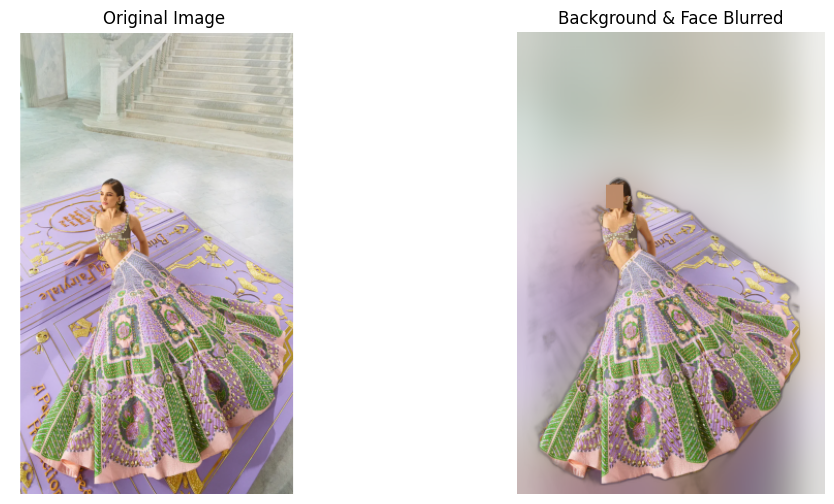

In [ ]:

import cv2
import numpy as np
from rembg import remove
from retinaface import RetinaFace
from matplotlib import pyplot as plt
from PIL import Image
import onnxruntime
# ----------------------------
# Load image
# ----------------------------
img_path = '/content/image.png'  
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ----------------------------
# Step 1: Rembg for background removal
# ----------------------------
# returns RGBA (alpha channel = mask)
foreground = remove(img_rgb)
foreground_np = np.array(foreground)

# Extract alpha channel as mask
alpha_mask = foreground_np[:, :, 3]
alpha_mask = cv2.merge([alpha_mask, alpha_mask, alpha_mask])

# Convert foreground to RGB
foreground_rgb = foreground_np[:, :, :3]

# Prepare blurred background
blurred_bg = cv2.GaussianBlur(img_rgb, (151,151), 0)

# Combine foreground and blurred background
alpha_norm = alpha_mask / 255.0
background_norm = 1 - alpha_norm
combined = (foreground_rgb * alpha_norm + blurred_bg * background_norm).astype(np.uint8)

# ----------------------------
# Step 2: RetinaFace for face detection & blur
# ----------------------------
faces = RetinaFace.detect_faces(img_path)

for key in faces.keys():
    face = faces[key]
    x1, y1, x2, y2 = face["facial_area"]
    # Extract face region
    face_region = combined[y1:y2, x1:x2]
    # Apply heavy blur
    face_blur = cv2.GaussianBlur(face_region, (101,101), 0)
    combined[y1:y2, x1:x2] = face_blur

# ----------------------------
# Step 3: Show results
# ----------------------------
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(combined)
plt.title("Background & Face Blurred")
plt.axis('off')
plt.show()


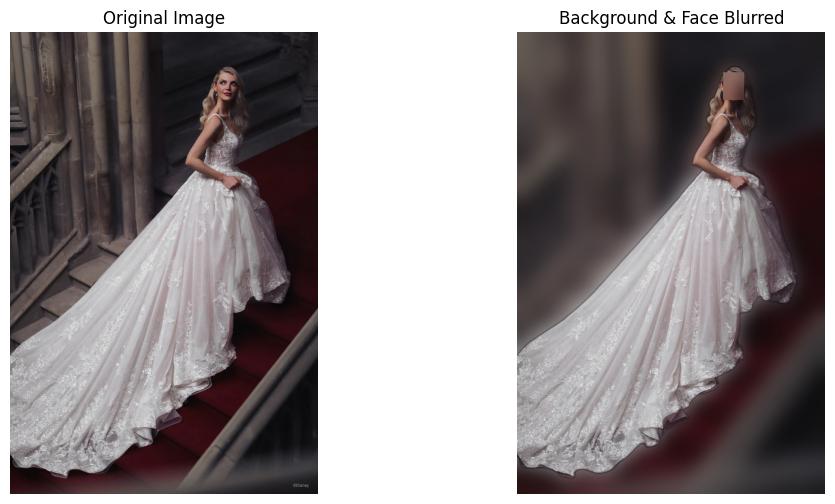

In [ ]:


import cv2
import numpy as np
from rembg import remove
from retinaface import RetinaFace
from matplotlib import pyplot as plt
from PIL import Image
import onnxruntime
# ----------------------------
# Load image
# ----------------------------
img_path = '/content/allurebg2_page18_img1.png'  
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# ----------------------------
# Step 1: Rembg for background removal
# ----------------------------
# returns RGBA (alpha channel = mask)
foreground = remove(img_rgb)
foreground_np = np.array(foreground)

# Extract alpha channel as mask
alpha_mask = foreground_np[:, :, 3]
alpha_mask = cv2.merge([alpha_mask, alpha_mask, alpha_mask])

# Convert foreground to RGB
foreground_rgb = foreground_np[:, :, :3]

# Prepare blurred background
blurred_bg = cv2.GaussianBlur(img_rgb, (151,151), 0)

# Combine foreground and blurred background
alpha_norm = alpha_mask / 255.0
background_norm = 1 - alpha_norm
combined = (foreground_rgb * alpha_norm + blurred_bg * background_norm).astype(np.uint8)

# ----------------------------
# Step 2: RetinaFace for face detection & blur
# ----------------------------
faces = RetinaFace.detect_faces(img_path)

for key in faces.keys():
    face = faces[key]
    x1, y1, x2, y2 = face["facial_area"]
    # Extract face region
    face_region = combined[y1:y2, x1:x2]
    # Apply heavy blur
    face_blur = cv2.GaussianBlur(face_region, (101,101), 0)
    combined[y1:y2, x1:x2] = face_blur

# ----------------------------
# Step 3: Show results
# ----------------------------
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(combined)
plt.title("Background & Face Blurred")
plt.axis('off')
plt.show()


Following is the actual script used for batch-wise processing:

In [ ]:


import os
import zipfile
import cv2
import numpy as np
from rembg import remove
from retinaface import RetinaFace
from tqdm import tqdm
from PIL import Image

# ----------------------------
# Paths
# ----------------------------
zip_folder ='/content/drive/My Drive/zipped_folder'
processed_folder = '/content/drive/My Drive/processed_folder'
os.makedirs(processed_folder, exist_ok=True)

# ----------------------------
# Process batch by batch
# ----------------------------
zip_files = [f for f in os.listdir(zip_folder) if f.lower().endswith('.zip')]

for zip_file in tqdm(zip_files, desc="Processing batches"):
    batch_name = os.path.splitext(zip_file)[0]
    batch_output_folder = os.path.join(processed_folder, batch_name)
    os.makedirs(batch_output_folder, exist_ok=True)

    # Unzip batch into temporary folder
    temp_input_folder = os.path.join('/content', 'temp_batch')
    if not os.path.exists(temp_input_folder):
        os.makedirs(temp_input_folder, exist_ok=True)
    else:
        # Clear previous contents
        for f in os.listdir(temp_input_folder):
            os.remove(os.path.join(temp_input_folder, f))

    with zipfile.ZipFile(os.path.join(zip_folder, zip_file), 'r') as zip_ref:
        zip_ref.extractall(temp_input_folder)

    # Process all images in the batch
    image_files = [f for f in os.listdir(temp_input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for img_file in tqdm(image_files, desc=f"Processing images in {batch_name}"):
        img_path = os.path.join(temp_input_folder, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue  # skip corrupted images
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Step 1: Rembg for background removal
        foreground = remove(img_rgb)
        fg_np = np.array(foreground)
        alpha_mask = fg_np[:, :, 3]
        alpha_mask_3ch = cv2.merge([alpha_mask]*3)
        foreground_rgb = fg_np[:, :, :3]

        blurred_bg = cv2.GaussianBlur(img_rgb, (151,151), 0)
        alpha_norm = alpha_mask_3ch / 255.0
        combined = (foreground_rgb * alpha_norm + blurred_bg * (1 - alpha_norm)).astype(np.uint8)

        # Step 2: RetinaFace for face blur
        faces = RetinaFace.detect_faces(img_path)
        if isinstance(faces, dict):
            for key in faces.keys():
                x1, y1, x2, y2 = faces[key]["facial_area"]
                face_region = combined[y1:y2, x1:x2]
                face_blur = cv2.GaussianBlur(face_region, (101,101), 0)
                combined[y1:y2, x1:x2] = face_blur

        # Step 3: Save output as PNG
        save_path = os.path.join(batch_output_folder, os.path.splitext(img_file)[0] + '.png')
        cv2.imwrite(save_path, cv2.cvtColor(combined, cv2.COLOR_RGB2BGR))

    # Step 4: Zip processed batch
    zip_save_path = os.path.join(processed_folder, batch_name + '_processed.zip')
    with zipfile.ZipFile(zip_save_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(batch_output_folder):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, batch_output_folder)
                zipf.write(file_path, arcname)

    # Optional: remove temporary processed images to save space
    for f in os.listdir(batch_output_folder):
        os.remove(os.path.join(batch_output_folder, f))

print("All batches processed, converted to PNG, and re-zipped!")


### 4. Resizing images 

The images were then resized to 256x256 (as opposed to 128x128 used for Fashion-MNIST, to preserve the intricate details) to match CycleGAN's input requirements. 

In [ ]:
import os
import zipfile
from PIL import Image
from tqdm import tqdm

# ----------------------------
# Paths
# ----------------------------
zip_folder = '/Users/sathammai/Desktop/processed_western'        # folder containing original zip files
processed_folder = '/Users/sathammai/Desktop/resized_western' # folder to save processed zips
os.makedirs(processed_folder, exist_ok=True)

# ----------------------------
# Parameters
# ----------------------------
resize_dim = (256, 256)

# ----------------------------
# Process batches
# ----------------------------
zip_files = [f for f in os.listdir(zip_folder) if f.lower().endswith('.zip')]

for zip_file in tqdm(zip_files, desc="Processing batches"):
    batch_name = os.path.splitext(zip_file)[0]
    batch_output_folder = os.path.join(processed_folder, batch_name)
    os.makedirs(batch_output_folder, exist_ok=True)

    # Unzip batch
    temp_input_folder = os.path.join('/Users/sathammai/Desktop/', 'temp_batch')
    if not os.path.exists(temp_input_folder):
        os.makedirs(temp_input_folder, exist_ok=True)
    else:
        # Clear previous contents
        for f in os.listdir(temp_input_folder):
            os.remove(os.path.join(temp_input_folder, f))

    with zipfile.ZipFile(os.path.join(zip_folder, zip_file), 'r') as zip_ref:
        zip_ref.extractall(temp_input_folder)

    # Resize and save as PNG
    image_files = [f for f in os.listdir(temp_input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for img_file in tqdm(image_files, desc=f"Resizing images in {batch_name}"):
        img_path = os.path.join(temp_input_folder, img_file)
        try:
            img = Image.open(img_path).convert("RGB")
            img_resized = img.resize(resize_dim, Image.LANCZOS)
            save_path = os.path.join(batch_output_folder, os.path.splitext(img_file)[0] + '.png')
            img_resized.save(save_path, format='PNG')
        except Exception as e:
            print(f"Skipping {img_file}, error: {e}")

    # Zip processed batch
    zip_save_path = os.path.join(processed_folder, batch_name + '_resized.zip')
    with zipfile.ZipFile(zip_save_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(batch_output_folder):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, batch_output_folder)
                zipf.write(file_path, arcname)

    # Optional: delete processed images to save space
    for f in os.listdir(batch_output_folder):
        os.remove(os.path.join(batch_output_folder, f))

print("All batches resized, converted to PNG, and re-zipped!")